<h1 align="center"> Лабораторная работа №2</h1>
<h1 align="center"> Создание модели </h1>

---

<h1 align="center"> Университет ИТМО </h1>
<h2 align="center"> Факультет систем управления и робототехники </h2>

---

<h2 align="center"> 65/35 </h2>

---

### Выполнили:
- **Бархоткина Анастасия 408226**
- **Лаврик Вадим 408969**
- **Юрков Кирилл 409936**

---

### Преподаватель:
- **Хитров Егор Германович**

---

### 2025 г.

---

## **Введение:**
### Цель работы: 
Изучить особенности метода сопряженных градиентов (Хестениса-Штифеля, Флетчера-Ривса) и его модификаций для решения задач минимизации квадратичного функционала; применить метод для обучения линейной модели на имеющихся данных.

### Задачи:
- Подготовить данные для обучения модели
- Реализовать методы Хестениса-Штифеля, Флетчера-Ривса
- Посторить графики убывания функции, нормы градиента, а также нормы вектора весов линейной модели α
- Проанализировать сходимость и особенности алгоритмов



## **Ход работы:**
В данной лабораторной работе мы будем находить минимум функционала потерь для линейной модели, обученной на выборке данных из датасета housing.csv. В качестве целевой переменной используется столбец MEDV (медианная стоимость жилья), а матрица признаков формируется из остальных столбцов датасета. Задача решается с использованием метода Хестениса-Штифеля (и его модификации - метода Флетчера-Ривса) для минимизации функционала:
$$
\rho^2 = \| X \alpha - y \|_2^2 \to \min_{\alpha},
$$
где X - матрица признаков, α - вектор весов линейной модели, y - вектор целевых значений.

### Подготовка данных

In [1]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import time  

Целевая переменная y задается как столбец MEDV. Матрицу признаков X будем формировать из всех столбцов, кроме целевого. Далее разделим данные на обучающую и тестовую выборки с заданной долей (65/35) и параметром random_state = 23.

In [2]:
data = pd.read_csv('housing.csv')
X = data.drop(columns=['MEDV']).values
y = data['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65, random_state=23)

Затем нормализуем обучающую выборку следующим образом: признаки центрируются и масштабируются, а целевая переменная стандартизируется.


In [3]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
y_train_mean = y_train.mean()
y_train_std = y_train.std()
y_train = (y_train - y_train_mean) / y_train_std

### Инициализация параметров
Начальный вектор весов α инициализируется нулями. Далее будем вычислять начальный градиент функционала и определять начальное направление спуска как: 
$d = -\text{grad}$.



### **Задание 1. Метод Хестенса-Штифеля**

Этот метод является одной из модификаций методов сопряженных градиентов, предназначенных для минимизации квадратичного функционала. Он особенно эффективен для задач оптимизации, где матрица Гессе (или эквивалентная ей матрица $X^T X$ в случае линейной регрессии) плохо обусловлена. 


Целевую функцию можно записать следующим образом:
$$
\rho^2 = (X\alpha - y)^T (X\alpha - y)
$$


Градиент функционала:
$$
\nabla \rho^2 = 2 X^T (X\alpha - y)
$$


Направление спуска $d_{k}$ на каждой итерации вычисляется как:
$$
d_k = -\mathrm{grad}_k + \beta_k \cdot d_{k-1},
$$
где $\mathrm{grad}_k$ - градиент функционала на текущей итерации, $d_{k-1}$ - направление спуска на предыдущей итерации, $\beta_k$ - коэффициент, который определяет связь между текущим и предыдущим направлениями.

Стоит отметить, что направления $d_{k}$ являются A-сопряженными, то есть удовлетворяют следующему условию:
$$
d_i^\top A d_j = 0, \quad i \neq j
$$


Коэффициент $\beta_k$ в этом методе будем вычислять по формуле, которая основана на разности текущего и предыдущего градиентов:
$$
\beta_k = \frac{\mathrm{grad}_k^\top (\mathrm{grad}_k - \mathrm{grad}_{k-1})}{d_{k-1}^\top (\mathrm{grad}_k - \mathrm{grad}_{k-1})}
$$



Разберем **механизм работы алгоритма**. После инициализации начальных параметров на каждой итерации k будут выполняться следующие шаги:
- **Вычисление шага $\gamma_k$.**

Длина шага в текущем направлении $d_{k}$ вычисляется как:
$$
\gamma_k = -\frac{\mathrm{grad}_k^\top d_k}{d_k^\top A d_k},
$$
где $A = 2X^\top X$ — Гессиан функционала.
- **Обновление вектора весов $\alpha_{k+1}$.**
$$
\alpha_{k+1} = \alpha_k + \gamma_k d_k
$$
- **Вычисление нового градиента** $\mathrm{grad}_{k+1}$.

$$
\mathrm{grad}_{k+1} = 2X^\top (X \alpha_{k+1} - y)
$$

- **Вычисление коэффициента** $\beta_k$ по формуле Хестенса-Штифеля.

$$
\beta_k = \frac{\mathrm{grad}_k^\top (\mathrm{grad}_{k+1} - \mathrm{grad}_k)}{d_k^\top (\mathrm{grad}_{k+1} - \mathrm{grad}_k)}
$$

- **Обновление направления спуска** $d_{k+1}$.

$$
d_{k+1} = -\mathrm{grad}_{k+1} + \beta_k d_k
$$

In [4]:
def shiphel(X_train, y_train):
    alpha = np.zeros(X_train.shape[1])
    grad = 2 * X_train.T @ (X_train @ alpha - y_train)
    d = -grad
    losses = []
    grad_norms = []
    alpha_norms = []
    start_time = time.time()  

    for k in range(100):
        losses.append(np.linalg.norm(X_train @ alpha - y_train) ** 2)
        grad_norms.append(np.linalg.norm(grad))
        alpha_norms.append(np.linalg.norm(alpha))
        if np.linalg.norm(grad) < 0.001:
            break
        A = 2 * X_train.T @ X_train 
        gamma_k = -(grad.T @ d) / (d.T @ A @ d)
        alpha = alpha + gamma_k * d

        grad_new = 2 * X_train.T @ (X_train @ alpha - y_train)
        beta_k = (grad_new.T @ (grad_new - grad)) / (d.T @ (grad_new - grad))
        d = -grad_new + beta_k * d
        grad = grad_new

    end_time = time.time() 
    execution_time=end_time-start_time
    return alpha, losses, grad_norms, alpha_norms, execution_time, k


#### Критерий остановки

Итерации продолжаются до тех пор, пока норма градиента не станет меньше заданного порога: $\|\mathrm{grad}_k\| < \varepsilon$. В нашем случае $\varepsilon = 0.001$.

In [5]:
alpha_shiphel, losses_shiphel, grad_norms_shiphel, alpha_norms_shiphel, execution_time_shiphel, iterations_shiphel = shiphel(X_train=X_train, y_train=y_train)
print(f"Время выполнения алгоритма: {execution_time_shiphel:.4f} секунд")
print(f"Количество итераций: {iterations_shiphel}")

Время выполнения алгоритма: 0.0000 секунд
Количество итераций: 14


Выведем графики:

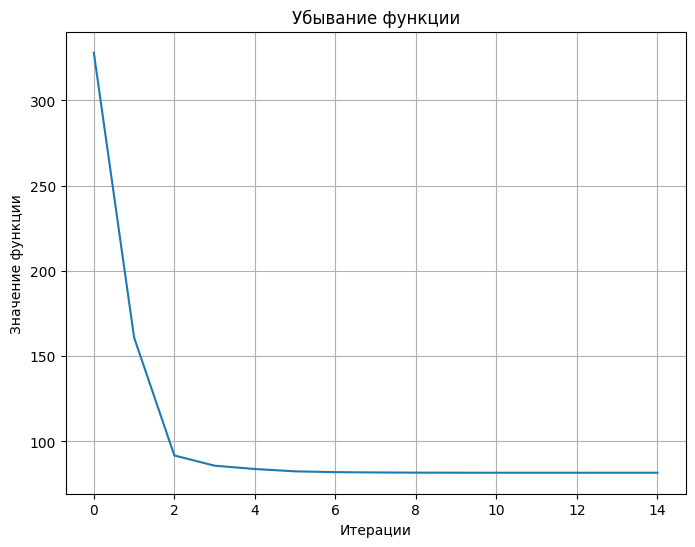

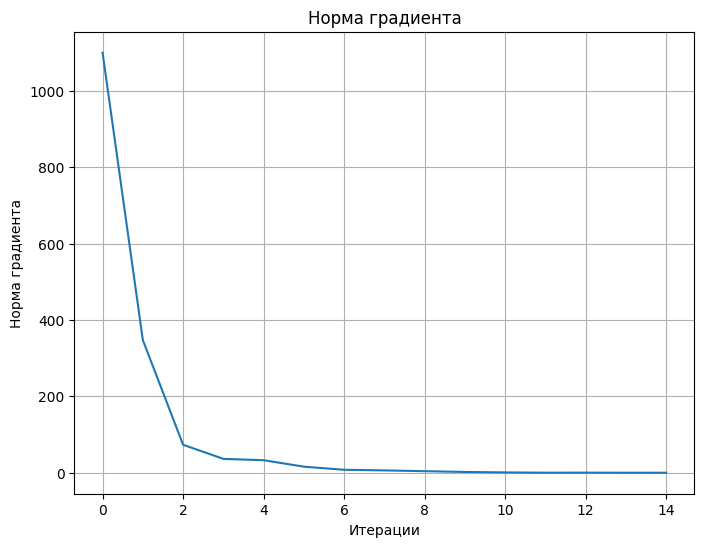

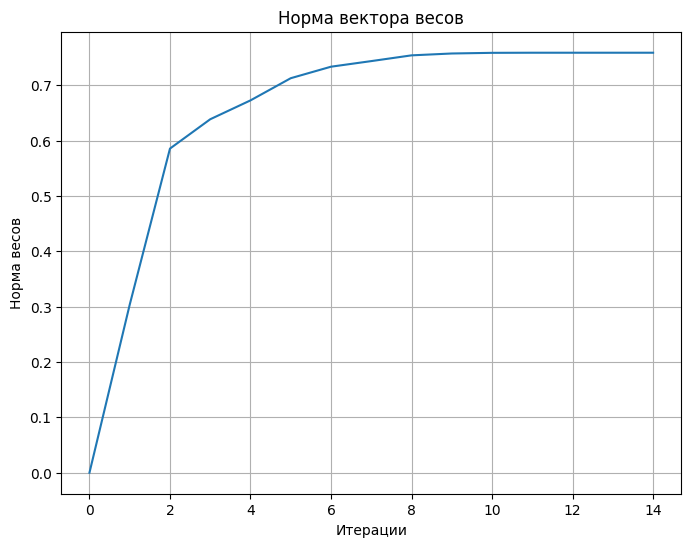

In [6]:
def visualize_plots_params(losses, grad_norms, alpha_norms):
    # Графики метрик
    plt.figure(figsize=(8, 6))
    plt.plot(losses)
    plt.title("Убывание функции")
    plt.xlabel("Итерации")
    plt.ylabel("Значение функции")
    plt.grid(True)

    plt.figure(figsize=(8, 6))
    plt.plot(grad_norms)
    plt.title("Норма градиента")
    plt.xlabel("Итерации")
    plt.ylabel("Норма градиента")
    plt.grid(True)

    plt.figure(figsize=(8, 6))
    plt.plot(alpha_norms)
    plt.title("Норма вектора весов")
    plt.xlabel("Итерации")
    plt.ylabel("Норма весов")
    plt.grid(True)
    plt.show()

visualize_plots_params(losses_shiphel, grad_norms_shiphel, alpha_norms_shiphel)

Посчитаем среднеквадратичную ошибку:

In [7]:
def calculate_mse(alpha):
    X_test_normalized = (X_test - X_mean) / X_std
    y_pred_normalized = X_test_normalized @ alpha
    y_pred = y_pred_normalized * y_train_std + y_train_mean

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred

mse_shiphel, r2_shiphel, y_pred_shiphel = calculate_mse(alpha_shiphel)
print(f"Среднеквадратичная ошибка (MSE): {mse_shiphel:.4f}")
print(f"Коэффициент детерминации (R^2): {r2_shiphel:.4f}")

Среднеквадратичная ошибка (MSE): 23.5925
Коэффициент детерминации (R^2): 0.6995


Теперь сравним предсказанные нашей моделью и истинные значения:

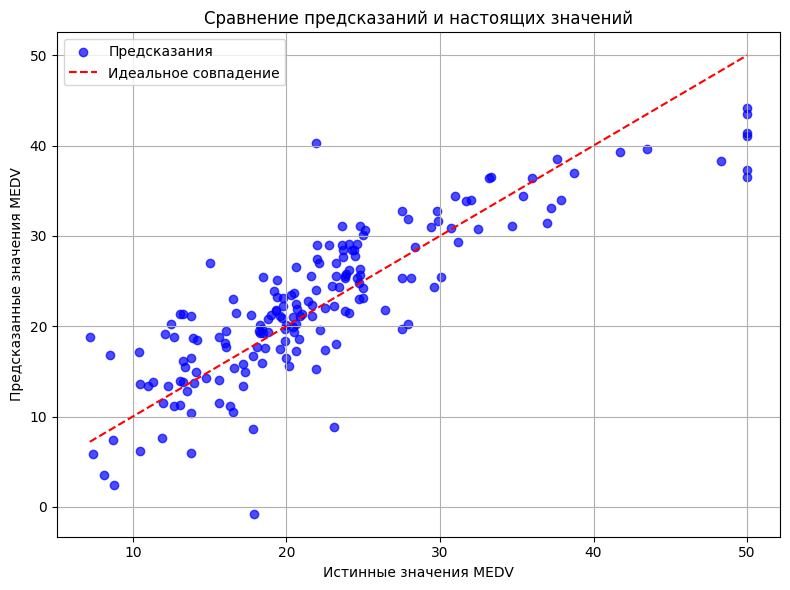

In [8]:
def visualize_predictions(y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Предсказания')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Идеальное совпадение")
    plt.xlabel("Истинные значения MEDV")
    plt.ylabel("Предсказанные значения MEDV")
    plt.title("Сравнение предсказаний и настоящих значений")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_predictions(y_pred_shiphel)

### Вывод по заданию 1.

Модель демонстрирует адекватное соответствие между предсказаниями и реальными значениями, при условиях, что исходная выборка делилась на 65/35(train/test). Наблюдается небольшое рассеяние точек, что указывает на наличие ошибок прогноза.

Значение функции на графике "Убывание функции" быстро уменьшается в первые несколько итераций (до 2-3 итераций), после чего снижение становится менее интенсивным. Это значит, что скорость сходимости высока в начальных итерациях, а затем замедляется, достигая плато.

График "Норма градиента" отражает изменение нормы градиента целевой функции во время обучения. Норма градиента резко уменьшается в первые несколько итераций.После этого она стабилизируется на малых значениях, близких к нулю, следовательно алгоритм приближается к минимуму функции потерь. Тогда, стабилизация градиента на малых значениях свидетельствует о достижении оптимального решения.

График "Норма вектора весов" показывает изменение нормы вектора весов (параметров модели) во время обучения.Норма вектора весов увеличивается в начале обучения, достигая некоторого максимального значения, после этого она стабилизируется, что указывает на то, что параметры модели больше не сильно изменяются. Следовательно,стабильность нормы весов после нескольких итераций указывает на сходимость алгоритма.

### **Задание 2. Метод Флетчера-Ривса**

В качестве второго алгоритма мы выбрали метод Флетчера-Ривса, который также является модификацией метода сопряженных градиентов. Он основан на идее построения последовательности сопряженных направлений, которые позволяют минимизировать функционал за меньшее количество шагов по сравнению с методом градиентного спуска. Однако, в отличие от метода Хестенса-Штифеля, метод Флетчера-Ривса использует другую формулу для вычисления коэффициента $\beta_k$, который определяет новое направление спуска, а именно: 
$$
\beta_k = \frac{\mathrm{grad}_{k+1}^\top \mathrm{grad}_{k+1}}{\mathrm{grad}_k^\top \mathrm{grad}_k}.
$$

Она основана только на текущем и предыдущем градиентах, что делает ее более простой для вычислений.

Опишем **механизм работы алгоритма**. После инициализации начальных параметров на каждой итерации k будут выполняться следующие шаги:
- **Вычисление шага $\gamma_k$.**
$$
\gamma_k = \frac{\mathrm{grad}_k^\top \mathrm{grad}_k}{d_k^\top (2X^\top X) d_k}
$$
- **Обновление вектора весов $\alpha_{k+1}$.**
- **Вычисление нового градиента** $\mathrm{grad}_{k+1}$.

Эти шаги выполняются по формулам, аналогичным предыдущему заданию.
- **Вычисление коэффициента** $\beta_k$ по формуле Флетчера-Ривса.

$$
\beta_k = \frac{\mathrm{grad}_{k+1}^\top \mathrm{grad}_{k+1}}{\mathrm{grad}_k^\top \mathrm{grad}_k}
$$

- **Обновление направления спуска** $d_{k+1}$.
Аналогично предыдущему алгоритму.




#### Критерий остановки
$$
\|\mathrm{grad}_k\| < 0.001
$$

In [9]:
def rivs(X_train, y_train):
    alpha = np.zeros(X_train.shape[1])
    grad = 2 * X_train.T @ (X_train @ alpha - y_train)
    d = -grad
    losses = []
    grad_norms = []
    alpha_norms = []
    start_time = time.time()

    for k in range(100):
        losses.append(np.linalg.norm(X_train @ alpha - y_train) ** 2)
        grad_norms.append(np.linalg.norm(grad))
        alpha_norms.append(np.linalg.norm(alpha))
        if np.linalg.norm(grad) < 0.001:
            break

        gamma_k = (grad.T @ grad) / (d.T @ (2 * X_train.T @ X_train @ d))
        alpha = alpha + gamma_k * d
        grad_new = 2 * X_train.T @ (X_train @ alpha - y_train)
        beta_k = (grad_new.T @ grad_new) / (grad.T @ grad)
        d = -grad_new + beta_k * d
        grad = grad_new

    end_time = time.time()
    execution_time=end_time-start_time
    return alpha, losses, grad_norms, alpha_norms, execution_time, k

alpha_rivs, losses_rivs, grad_norms_rivs, alpha_norms_rivs, execution_time_rivs, iterations_rivs=rivs(X_train=X_train, y_train=y_train)

Выведем результаты работы алгоритма:

In [15]:
print(f"Время выполнения алгоритма: {execution_time_rivs:.4f} секунд")
print(f"Количество итераций: {iterations_rivs}")

Время выполнения алгоритма: 0.0012 секунд
Количество итераций: 14


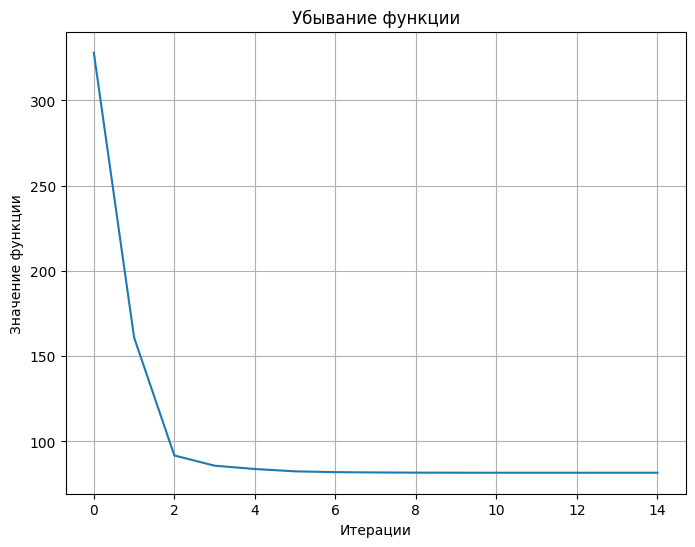

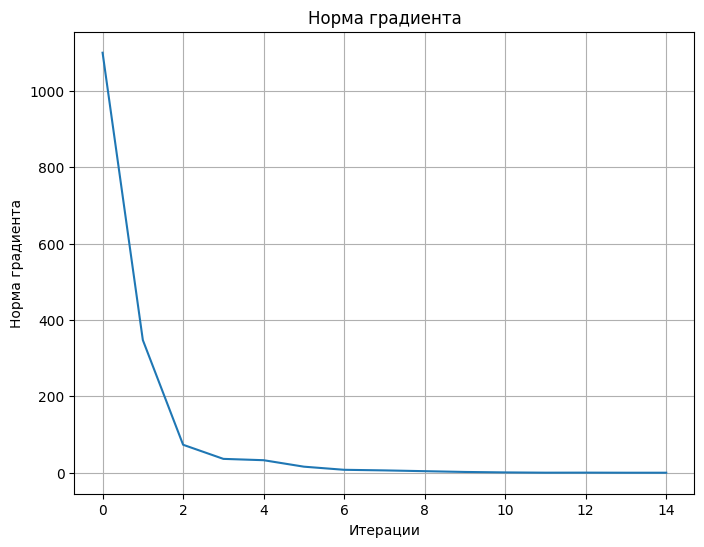

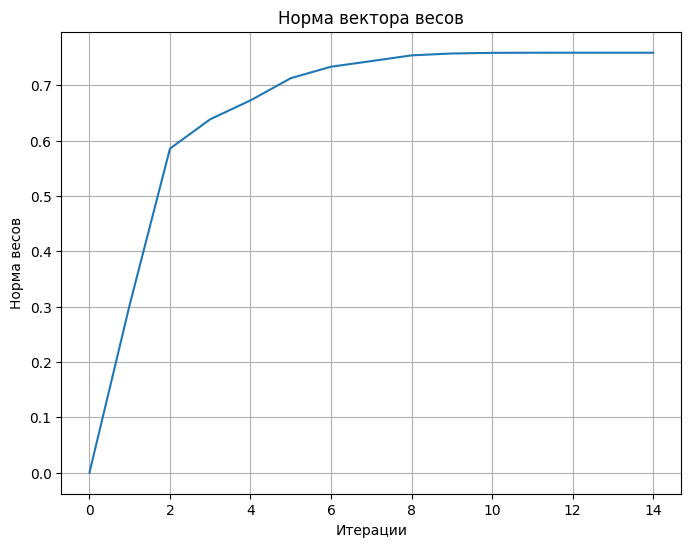

In [11]:
visualize_plots_params(losses_rivs, grad_norms_rivs, alpha_norms_rivs)

Посчитаем квадратичную ошибку, а также выведем предсказания модели:

In [12]:
mse_rivs, r2_rivs, y_pred_rivs =calculate_mse(alpha_rivs)

print(f"Среднеквадратичная ошибка (MSE): {mse_rivs:.4f}")
print(f"Коэффициент детерминации (R^2): {r2_rivs:.4f}")

Среднеквадратичная ошибка (MSE): 23.5925
Коэффициент детерминации (R^2): 0.6995


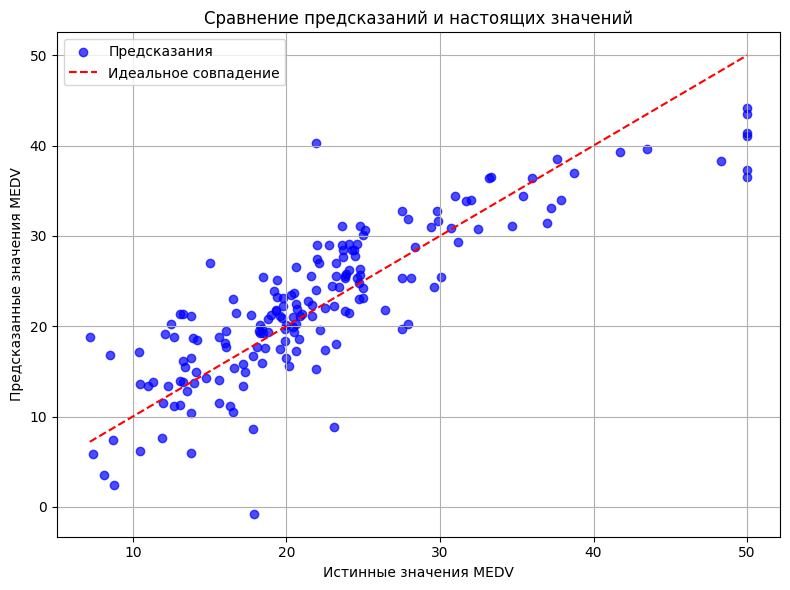

In [13]:
visualize_predictions(y_pred_rivs)

#### Вывод по заданию 2.

Результаты алгоритма Флетчера-Ривса полностью совпадают с результатами алгоритма Хестенса-Штифеля. Соответственно вывод к алгоритму Хестенса-Шифеля полностью аналогичен выводу к работе алгоритма Флетчера-Ривса.

### **Вывод.**

In [14]:
tabledata=[['Хестенса-Штифеля', execution_time_shiphel, iterations_shiphel, mse_shiphel, r2_shiphel], ['Флетчера-Ривса', execution_time_rivs, iterations_rivs, mse_rivs, r2_rivs]]
pd.DataFrame(tabledata, columns=["Алгоритм","Время выполнения (с)", "Количество итераций", "Среднеквадратичная ошибка (MSE)", "Коэффициент детерминации"])

,Алгоритм,Время выполнения (с),Количество итераций,Среднеквадратичная ошибка (MSE),Коэффициент детерминации
0,Хестенса-Штифеля,0.000000,14,23.592485,0.699546
1,Флетчера-Ривса,0.001199,14,23.592485,0.699546


Совпадение результатов работы алгоритмов Хестенса-Штифеля и Флетчера-Ривса объясняется тем, что оба метода относятся к классу методов сопряжённых градиентов и отличаются только способом вычисления параметров, которые используются для построения нового направления поиска. Однако в случае квадратичной целевой функции, эти методы дают одинаковые результаты.

Неточность модели объясняется малым объёмом тренировочной выборки. Всего-лишь 65% от исходной, когда вся выборка представляет собой лишь 500 элементов, из-за чего каждые 5% от объёма такой малой выборки могут быть ключевыми при обучении модели.